## ${\textbf{⚠️Warning⚠️}}$
**Not trying to solve the problem. Just using an open dataset to keep some useful functions and clean track of metrics by model.**<br><br>
## ${\textbf{Imports}}$

In [1]:
import pandas as pd
import time
from datetime import datetime
import warnings

import re
import math
import statistics #stdev

#xgboost
from xgboost import XGBClassifier

#sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

#Viz
import matplotlib.pyplot as plt 
import seaborn as sn
from wordcloud import WordCloud

##Strings in lists count, converts
from itertools import groupby
import join
from sklearn.utils import shuffle

# Print in colors
from termcolor import colored

## <font color = Darkblue>${\textbf{Read dataset}}$</font> <span style='font-size:30px;'>&#128194;</span>

In [2]:
pd.set_option("max_colwidth", 130)
pd.set_option('display.max_columns', None)
pd.set_option("display.width", 300)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('C:/achraf/Desktop/codes et commandes/git_wwsssuuup/IMDB Dataset.csv')

print('\nNumber of rows and columns:', df.shape)
print('\nnumber of duplicates:', len(df)-len(df.drop_duplicates()))
print('\nNumber of missings: ')
print(df.isnull().sum()/len(df)*100)
print('\nColumns types: ')
print(df.dtypes)
print('-----------------------------------------------------')
df.tail(1)


Number of rows and columns: (50000, 2)

number of duplicates: 418

Number of missings: 
review       0.0
sentiment    0.0
dtype: float64

Columns types: 
review       object
sentiment    object
dtype: object
-----------------------------------------------------


,review,sentiment
49999,"No one expects the Star Trek movies to be high art, but the fans do expect a movie that is as good as some of the best episode...",negative


In [4]:
df = df.drop_duplicates()

In [5]:
df.rename(columns={'sentiment' : 'label'}, inplace = True) # rename column

# ${\textbf{EDA_1*}}$

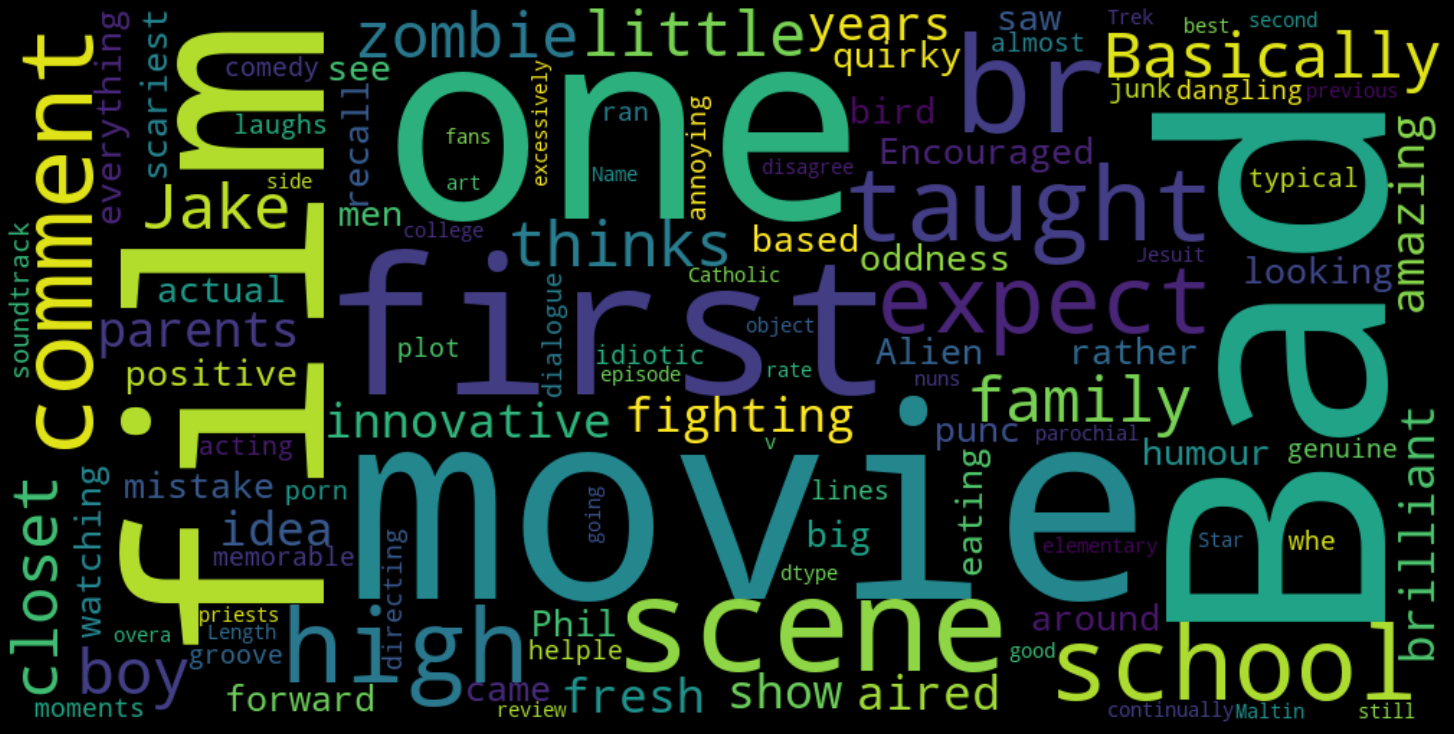

In [6]:
df_negative = df.loc[df.label == 'negative']

text = df_negative['review']
wordcloud = WordCloud(
    width = 1000,
    height = 500,
    background_color = 'black').generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

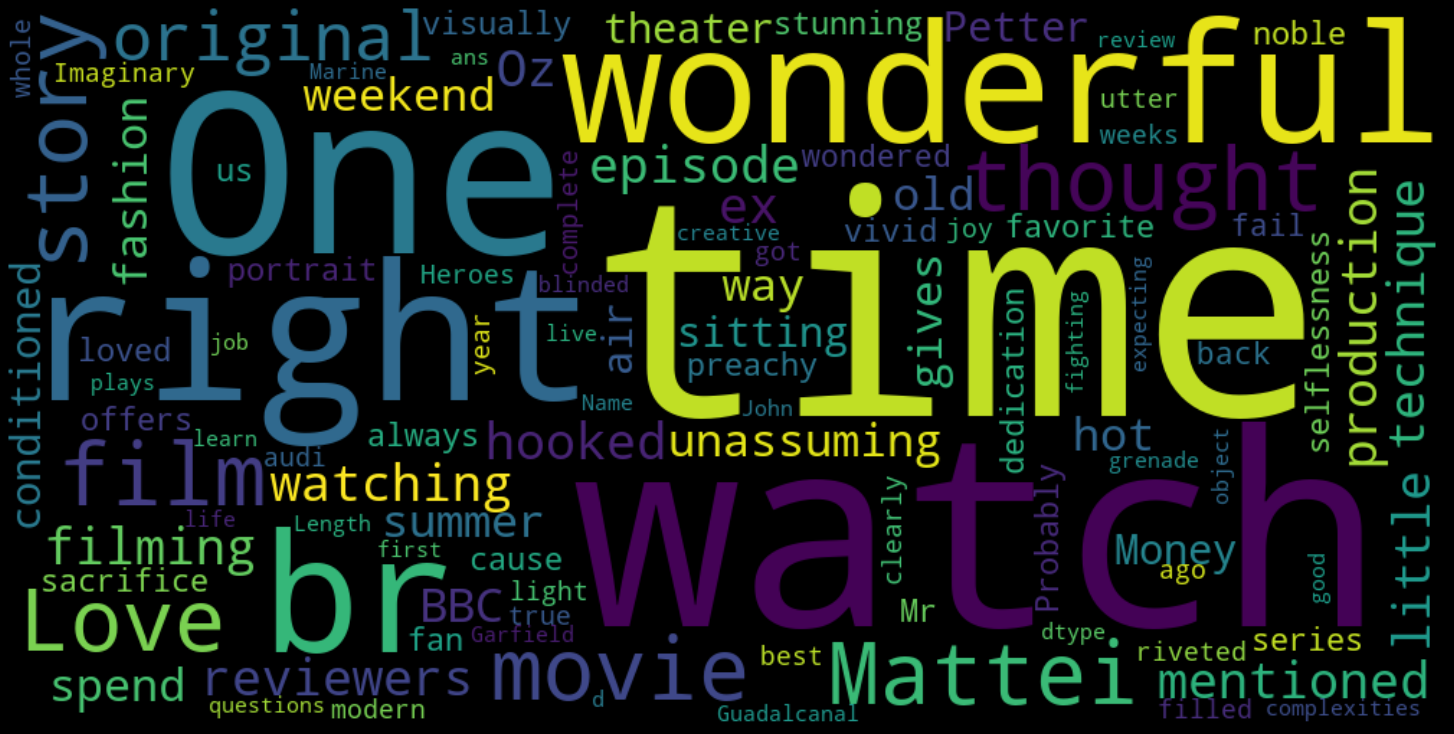

In [7]:
df_positive = df.loc[df.label == 'positive']

text = df_positive['review']
wordcloud = WordCloud(
    width = 1000,
    height = 500,
    background_color = 'black').generate(str(text))
fig = plt.figure(
    figsize = (20, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# ${\textbf{Preprocessing*}}$ <span style='font-size:30px;'>&#10024;</span>

In [8]:
df = df.sample(10000) # Take a subset for faster code test

In [9]:
#Digit Count
def digit_count(review):
    count=0
    for c in review:
        if c.isnumeric():
            count+=1
    return count


#Letter Count
def letter_count(review):
    count=0
    for c in review:
        if c.isalpha(): # The isalpha() method returns True if all the characters are alphabet letters (a-z).
            count+=1
    return count


# Check special charcters
'''Non exhaustive list'''
def checkSpecial(string): 
    regex = re.compile('[-@_!#$%^&*()<>?|}{~]') 
    i=0
    for char in string:   
        if regex.search(char):
            i+=1
    return i


# Compute entropy
def entropy(review):
        string = review.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy


# Average word length
def avg_word_length(review):
    words = list(filter(None, re.split(r"\d*\W+", review)))
    average = sum(len(word) for word in words) / len(words)
    return average

In [10]:
def feature_transform(df):
    switch = {'words_avg' : avg_word_length, 'digits_count' : digit_count, 'letter_count' : letter_count,
              'specialChar' : checkSpecial, 'entropy' : entropy}
    for key in switch:
        df.insert(1, key, [switch[key](review) for review in df['review']])

# Transform Dataset(feature_transform): add computed features
feature_transform(df)

df['num.'] = df['review'].apply(lambda i: i.count('.'))

In [11]:
df.sample(3)

,review,entropy,specialChar,letter_count,digits_count,words_avg,label,num.
21022,I won't repeat all that has been said already by other viewers of this film.<br /><br />In my opinion this is an excellent fil...,-4.324046,15,561,0,4.125000,positive,4
3384,"After the across-the-board success of MY NAME IS BARBRA, CBS television permitted Barbra to create an even more elaborate foll...",-4.554270,34,3558,0,4.814614,positive,27
13822,I just recently watched this 1954 movie starring Vincent Price for the first time on Turner Classic Movies. Price portrays Don...,-4.481899,12,583,4,4.383459,positive,5


In [12]:
df.columns

Index(['review', 'entropy', 'specialChar', 'letter_count', 'digits_count', 'words_avg', 'label', 'num.'], dtype='object')

In [13]:
df.describe()

,entropy,specialChar,letter_count,digits_count,words_avg,num.
count,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.000000
mean,-4.413962,15.577000,1016.01020,3.15200,4.269135,12.982400
std,0.114262,16.582436,777.25851,5.27527,0.302760,9.864229
min,-5.172394,0.000000,42.00000,0.00000,3.175439,0.000000
25%,-4.482052,4.000000,540.00000,0.00000,4.065825,7.000000
50%,-4.413719,11.000000,751.00000,2.00000,4.253440,10.000000
75%,-4.341712,22.000000,1235.00000,4.00000,4.455179,16.000000
max,-1.930888,282.000000,10228.00000,107.00000,7.500000,154.000000


In [14]:
df_backup = df.copy()

# ${\textbf{Statistics}}$

## <font color = grey>${\textbf{EDA_2*}}$</font>

<AxesSubplot:>

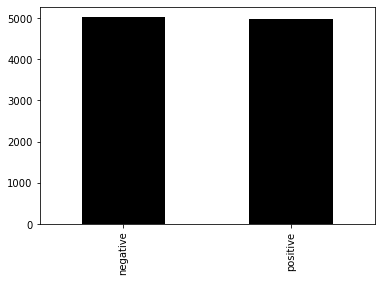

In [15]:
df['label'].value_counts().plot(kind = 'bar', color = 'black')

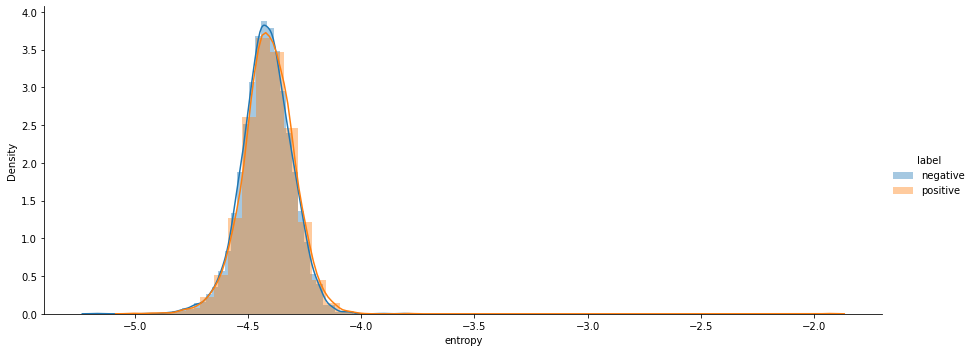

In [16]:
sn.FacetGrid(df, hue = "label", size = 5, height = 20, aspect = 2.5).map(sn.distplot, 'entropy').add_legend()

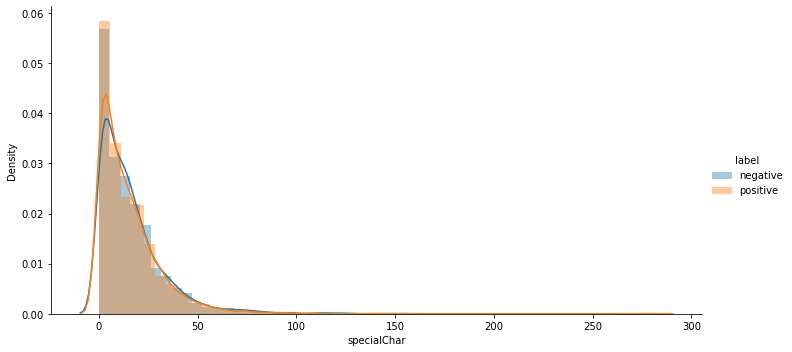

In [17]:
sn.FacetGrid(df, hue = "label", size = 5, height = 20, aspect = 2).map(sn.distplot, 'specialChar').add_legend()

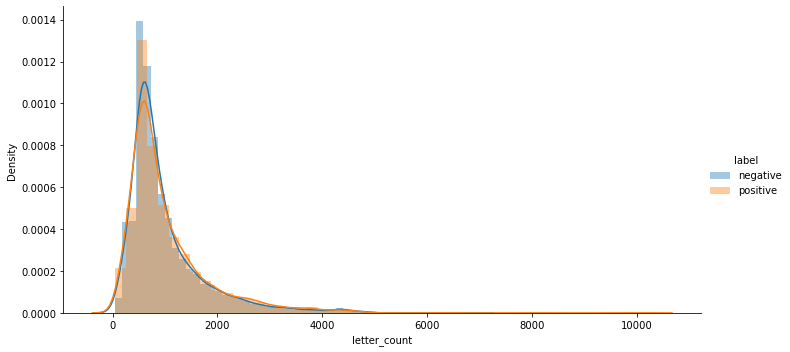

In [18]:
sn.FacetGrid(df, hue = "label", size = 5, height = 20, aspect = 2).map(sn.distplot, 'letter_count').add_legend()

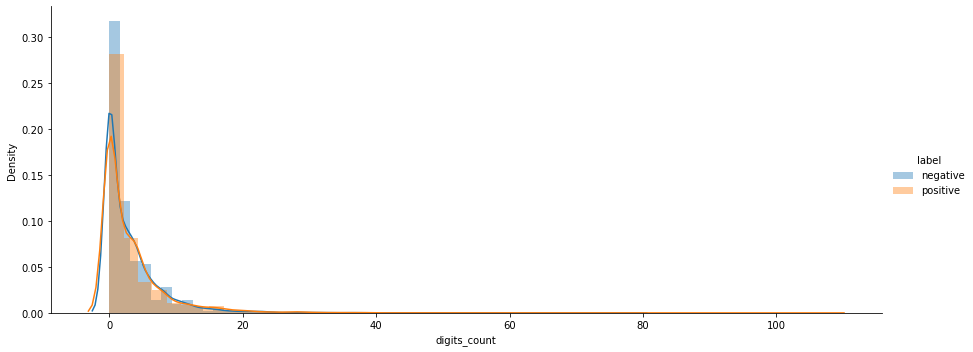

In [19]:
sn.FacetGrid(df, hue = "label", size = 5, height = 20, aspect = 2.5).map(sn.distplot, 'digits_count').add_legend()

<AxesSubplot:xlabel='words_avg', ylabel='Density'>

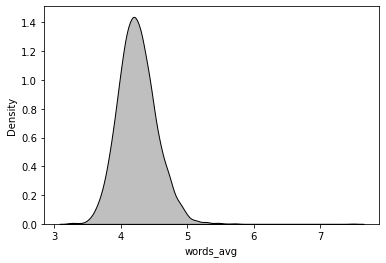

In [20]:
sn.kdeplot((df.loc[df.label == 'negative']['words_avg']), shade = True, color = 'black')

<AxesSubplot:xlabel='words_avg', ylabel='Density'>

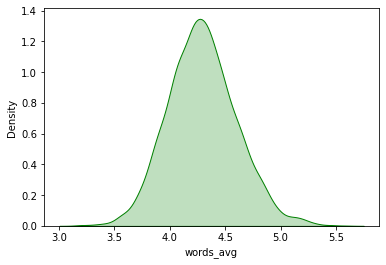

In [21]:
sn.kdeplot((df.loc[df.label == 'positive']['words_avg']), shade = True, color = 'green')

## <font color = grey>${\textbf{Correlation Matrix*}}$</font> <span style='font-size:30px;'>&#127826;</span>

In [22]:
df.columns

Index(['review', 'entropy', 'specialChar', 'letter_count', 'digits_count', 'words_avg', 'label', 'num.'], dtype='object')

In [23]:
corrMatrix = df.corr()

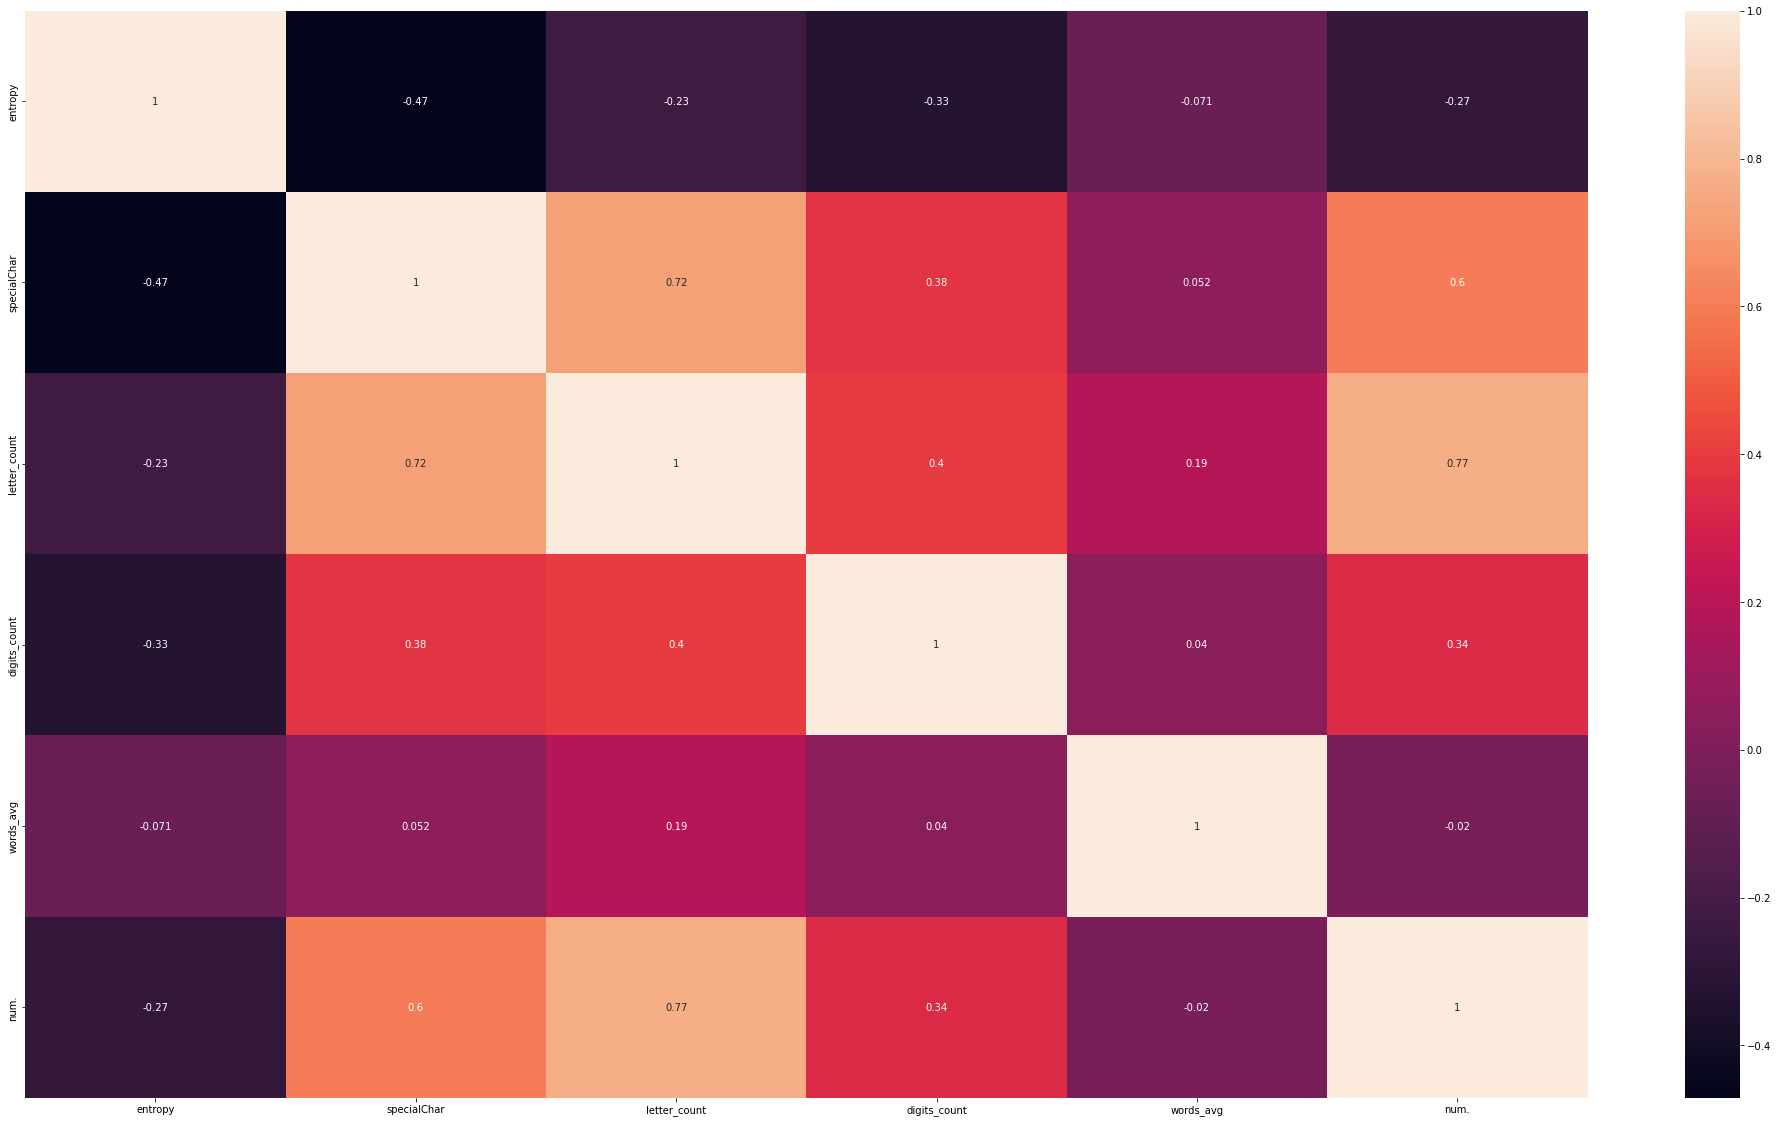

In [24]:
plt.subplots(figsize=(35,20))
sn.heatmap(corrMatrix, annot=True)
plt.show()

# plt.savefig('C:/Desktop/data/modelisation data/corr.png')

In [25]:
df = df.drop(['review'], axis = 1)
df = df.replace({'negative': 1, 'positive': 0})

In [26]:
df.tail()

,entropy,specialChar,letter_count,digits_count,words_avg,label,num.
43945,-4.432463,10,868,3,3.666667,1,13
43099,-4.321723,1,540,1,4.153846,1,10
33988,-4.418094,2,581,4,4.611111,1,5
23118,-4.375854,24,2095,3,4.293033,1,27
49401,-4.388298,42,2347,4,4.395131,0,18


# ${\textbf{Modelisation: Baseline}}$

## <font color = grey>${\textbf{Train Test Split}}$</font>

In [27]:
y = df.label
X = df[df.columns.difference(['label'])]

In [28]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 26)

In [29]:
y = y_train
X = X_train

In [30]:
X_train.shape

(7000, 6)

In [31]:
X_valid.shape

(3000, 6)

In [32]:
print('features shape: ' + str(X.shape))
print('target shape: ' + str(y.shape))

features shape: (7000, 6)
target shape: (7000,)


### <font color = darkgrey>${\textbf{Correlation between features and label}}$</font>

<AxesSubplot:xlabel='label'>

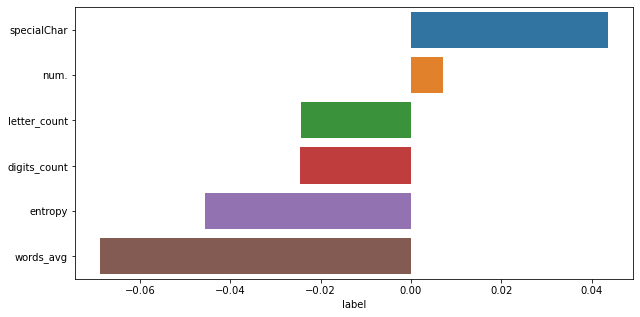

In [33]:
h_data = X.copy()
h_data['label'] = y

phish_corr = h_data.corr()['label'].drop('label').sort_values(ascending=False)
plt.figure(figsize=(10,5))
sn.barplot(x=phish_corr, y=phish_corr.index)

## <font color = grey>${\textbf{Random Forest}}$</font>

In [34]:
def gridsearch_rf_model(params, X=X):

    start = time.time() # start timer

    rf_model = RandomForestClassifier(random_state = 26) # init model
    rf_grid = GridSearchCV(estimator = rf_model, param_grid = params, cv=5, scoring='precision') #optimize for f1 : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    rf_grid = rf_grid.fit(X, y) # fit model

    end = time.time() # end timer
    print('Model fit time in seconds: \n' + str(end-start))
    print("Best params: \n", rf_grid.best_params_)
    print('Best precision score: \n', rf_grid.best_score_)

    return rf_grid

In [35]:
params = {'n_estimators':[40, 50], #number of trees 90, 100, 120, 180, 200
          'max_depth': [10, 20], #decision level depth  5 , 50
          'min_samples_leaf': [15, 20] #min number of samples on final (decision) nodes - leaves.  35, 40, 45, 50, 55, 60
         }

rf_grid = gridsearch_rf_model(params)

Model fit time in seconds: 
9.287967681884766
Best params: 
 {'max_depth': 10, 'min_samples_leaf': 15, 'n_estimators': 40}
Best precision score: 
 0.5400276124202756


In [36]:
params = {'n_estimators':[20], #number of trees
          'max_depth': [20], #decision level depth 
          'min_samples_leaf': [15] #min number of samples on final (decision) nodes - leaves.
         }

rf_grid = gridsearch_rf_model(params)

Model fit time in seconds: 
0.706653356552124
Best params: 
 {'max_depth': 20, 'min_samples_leaf': 15, 'n_estimators': 20}
Best precision score: 
 0.5267584793504927


In [37]:
y_pred = rf_grid.predict(X_valid)

In [38]:
print("Accuracy:", metrics.accuracy_score(y_valid, y_pred))

Accuracy: 0.529


In [39]:
conf_mat = confusion_matrix(y_valid, y_pred)
print(conf_mat)

[[791 685]
 [728 796]]


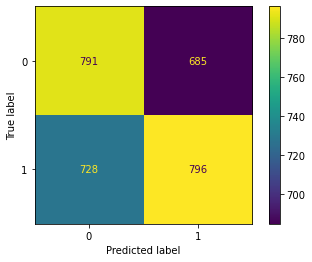

In [40]:
# Visualize confusiuon matrix
disp = plot_confusion_matrix(rf_grid, X_valid, y_valid, values_format = '.0f')

In [41]:
print("Error for positive reviews is : {0:.2%}".format(3596/(50382+3596)))

Error for positive reviews is : 6.66%


In [42]:
print("Error for negative reviews is : {0:.2%}".format(3550/(42045+3550)))

Error for negative reviews is : 7.79%


In [43]:
params = {'n_estimators':[180, 200, 210], #number of trees 90, 100, 120, 180, 200
          'max_depth': [30, 40, 50], #decision level depth  5 , 50
          'min_samples_leaf': [10] #min number of samples on final (decision) nodes - leaves. 35, 40, 45, 50, 55, 60
         }

rf_grid = gridsearch_rf_model(params)

Model fit time in seconds: 
56.333383560180664
Best params: 
 {'max_depth': 30, 'min_samples_leaf': 10, 'n_estimators': 200}
Best precision score: 
 0.5318822517534432


<font color = green>${\textbf{Random Forest, same model with same HyperParameters, with no cross-val nor GridSearch}}$</font>

In [44]:
clf = RandomForestClassifier(max_depth = 40, min_samples_leaf = 10, n_estimators = 230)

clf.fit(X, y)

y_pred = clf.predict(X_valid)
print("Accuracy: " , metrics.accuracy_score(y_valid, y_pred))

Accuracy:  0.5526666666666666


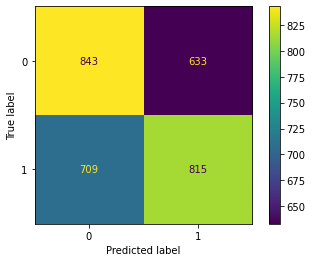

In [45]:
# Visualize confusiuon matrix
disp = plot_confusion_matrix(clf, X_valid, y_valid, values_format = '.0f')

In [46]:
print("Error for positive reviews is : {0:.2%}".format(3562 / (50416 + 3562)))

Error for positive reviews is : 6.60%


In [47]:
print("Error for negative reviews is : {0:.2%}".format(3360 / (42235 + 3360)))

Error for negative reviews is : 7.37%


<font color = green>${\textbf{Feature Importance}}$</font>

<AxesSubplot:>

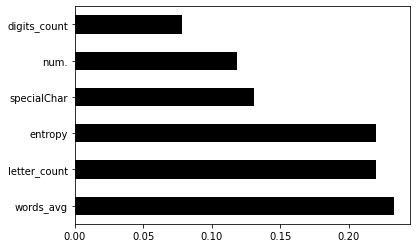

In [48]:
feat_importances = pd.Series(clf.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind='barh', color="black")

In [49]:
feat_importances.nlargest(20).index

Index(['words_avg', 'letter_count', 'entropy', 'specialChar', 'num.', 'digits_count'], dtype='object')

In [50]:
results = pd.DataFrame(columns=['Model','Precision','Recall','Accuracy', 'F1_score'])

def model_scores(model, model_name):
    """
    Save and return  accuracy, precision and 
    recall scores for the input model, for various feature sets. 
    """
    accuracy = metrics.accuracy_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred, average="macro")
    recall = recall_score(y_valid, y_pred, average="macro")
    f1Score = metrics.f1_score(y_valid, y_pred, average = "macro")

    results.loc[len(results),:] = [model_name, precision, recall, accuracy, f1Score]
    
    print(colored('\n Results for each classification algorithm:', 'magenta', attrs=['bold']))
    return results 

In [51]:
model_scores(clf, 'Random Forest')


 Results for each classification algorithm:


,Model,Precision,Recall,Accuracy,F1_score
0,Random Forest,0.553008,0.552958,0.552667,0.552628


## <font color = grey>${\textbf{Logistic Regression}}$</font>

In [52]:
def gridsearch_lr_model(params, X = X):
    start = time.time() #start timer
    model = LogisticRegression(random_state = 26) #set model 
    lr_grid = GridSearchCV(estimator = model, param_grid=params, cv = 5, scoring = 'precision') #gridsearch with 5 fold cross validation 
    lr_grid = lr_grid.fit(X, y) #fit regression model    
    end = time.time() #end timer
    return lr_grid

In [53]:
#Create a dictionary with the gridsearch parameters
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1],
          'penalty': ['l1','l2']} #searching over Lasso and Ridge

lr_grid = gridsearch_lr_model(params)

In [54]:
logisticRegr = LogisticRegression(C = 0.001, penalty = 'l2')

In [55]:
logisticRegr.fit(X_train, y_train)

LogisticRegression(C=0.001)

In [56]:
y_pred = logisticRegr.predict(X_valid)
print("Accuracy: " , metrics.accuracy_score(y_valid, y_pred))

Accuracy:  0.5416666666666666


In [57]:
model_scores(logisticRegr, 'Logistic Regression')


 Results for each classification algorithm:


,Model,Precision,Recall,Accuracy,F1_score
0,Random Forest,0.553008,0.552958,0.552667,0.552628
1,Logistic Regression,0.542775,0.542419,0.541667,0.540992


## <font color = grey>${\textbf{Decision Tree}}$</font>

In [58]:
def gridsearch_dt_model(params, X = X):
    start = time.time()
    dt_model = DecisionTreeClassifier(random_state = 26) # init decision tree
    dt_grid = GridSearchCV(estimator = dt_model, param_grid = params, cv = 5, scoring = 'precision') # 5fold cv, optimised for precision
    dt_grid = dt_grid.fit(X, y) # fit model
    end = time.time()
    return dt_grid

In [59]:
params = {'min_samples_leaf': [5],
          'max_depth': [50]}

dt_model = gridsearch_dt_model(params)

In [60]:
dt_clf = DecisionTreeClassifier(max_depth = 50, min_samples_leaf = 5, min_impurity_decrease = 0.01)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, min_impurity_decrease=0.01,
                       min_samples_leaf=5)

In [61]:
y_pred = dt_clf.predict(X_valid)
print("Accuracy: " , metrics.accuracy_score(y_valid, y_pred))

Accuracy:  0.492


In [62]:
model_scores(dt_clf, 'Decision Tree')


 Results for each classification algorithm:


,Model,Precision,Recall,Accuracy,F1_score
0,Random Forest,0.553008,0.552958,0.552667,0.552628
1,Logistic Regression,0.542775,0.542419,0.541667,0.540992
2,Decision Tree,0.246,0.5,0.492,0.329759


## <font color = grey>${\textbf{KNN}}$</font>

In [63]:
def gridsearch_knn_model(params, X = X):
    start = time.time() # start timer
    knn_model = KNeighborsClassifier(n_jobs = 4) # using all cores 
    knn_grid = GridSearchCV(estimator = knn_model, param_grid = params, cv = 5, scoring = 'precision') # 5 fold cv
    knn_grid = knn_grid.fit(X, y) # fit model
    end = time.time() # stop timer
    return knn_grid

In [64]:
params = {'n_neighbors':[500, 550, 600, 800, 1000]}

knn_grid = gridsearch_knn_model(params)

In [65]:
k_neigh = KNeighborsClassifier(n_neighbors = 500, weights = 'distance', p = 1, n_jobs = 5)

In [66]:
k_neigh.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=5, n_neighbors=500, p=1, weights='distance')

In [67]:
y_pred = k_neigh.predict(X_valid)
print("Accuracy: ", metrics.accuracy_score(y_valid, y_pred))

Accuracy:  0.5273333333333333


In [68]:
model_scores(k_neigh, 'K-nearest neighbors')


 Results for each classification algorithm:


,Model,Precision,Recall,Accuracy,F1_score
0,Random Forest,0.553008,0.552958,0.552667,0.552628
1,Logistic Regression,0.542775,0.542419,0.541667,0.540992
2,Decision Tree,0.246,0.5,0.492,0.329759
3,K-nearest neighbors,0.529111,0.528503,0.527333,0.525348


## <font color = DArkred>${\textbf{SVM_0}}$</font>

In [69]:
from sklearn import svm

In [70]:
svm_clf = svm.SVC()
grid = {'gamma' : ['auto']} #### , 1e3, 5e3, 1e4, 5e4, 1e5   ####   , 5e-4, 1e-4, 5e-3
svm_clf_grid = GridSearchCV(svm_clf, grid)
svm_clf_grid.fit(X_train, y_train)

GridSearchCV(estimator=SVC(), param_grid={'gamma': ['auto']})

In [71]:
svm_clf_grid.best_estimator_

SVC(gamma='auto')

In [72]:
svm_clf_grid.predict(X_valid)

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

## <font color = grey>${\textbf{Sklearn Gradient Boosing}}$</font>

In [73]:
from sklearn.metrics import classification_report, confusion_matrix,roc_curve
from sklearn.ensemble import GradientBoostingClassifier

In [74]:
# Train and evaluate model
larningRate_list = [0.075, 0.1, 0.25, 0.5, 0.75]

# Fit for every learning rate to get best.
for learning_rate in larningRate_list:
    gb_clf = GradientBoostingClassifier(n_estimators = 40,
                                        learning_rate = learning_rate,
                                        max_features = 5, max_depth = 4, random_state = 26)
    gb_clf.fit(X_train, y_train)
    
    print("----------------------------------")
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_valid, y_valid)))

----------------------------------
Learning rate:  0.075
Accuracy score (training): 0.619
Accuracy score (validation): 0.546
----------------------------------
Learning rate:  0.1
Accuracy score (training): 0.624
Accuracy score (validation): 0.546
----------------------------------
Learning rate:  0.25
Accuracy score (training): 0.667
Accuracy score (validation): 0.532
----------------------------------
Learning rate:  0.5
Accuracy score (training): 0.691
Accuracy score (validation): 0.529
----------------------------------
Learning rate:  0.75
Accuracy score (training): 0.711
Accuracy score (validation): 0.524



 Classification Report: 

              precision    recall  f1-score   support

           0       0.52      0.52      0.52      1476
           1       0.53      0.53      0.53      1524

    accuracy                           0.52      3000
   macro avg       0.52      0.52      0.52      3000
weighted avg       0.52      0.52      0.52      3000


 Gradient Boosting training score: 0.7112857142857143

 Confusion Matrix: 



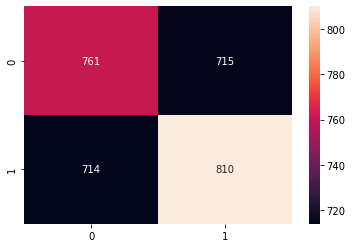

In [75]:
# Model evaluation & Confusion matrix
gb_clf = GradientBoostingClassifier(n_estimators = 40, learning_rate = 0.75, max_features = 5, max_depth = 4, 
                                    random_state = 26)

gb_clf.fit(X_train, y_train)
y_pred = gb_clf.predict(X_valid)

# Classification Report
print(colored('\n Classification Report: \n', 'red', attrs=['bold']))
print(classification_report(y_valid, y_pred))

# Score
Gdboost_score = gb_clf.score(X_train, y_train)
print(colored('\n Gradient Boosting training score:', 'red', attrs=['bold']), Gdboost_score)

# Confusion matrix
print(colored('\n Confusion Matrix: \n', 'red', attrs=['bold']))
confusion_matrice = confusion_matrix(y_valid, y_pred)
sn.heatmap(confusion_matrice, annot = True, fmt='g')
plt.show()

**Unlike the Sklearn's gradient boosting, Xgboost does regularization of the tree as well to avoid overfitting and it deals with the missing values efficiently as well.**

In [76]:
model_scores(gb_clf, 'Sklearn Gradient Boosting')


 Results for each classification algorithm:


,Model,Precision,Recall,Accuracy,F1_score
0,Random Forest,0.553008,0.552958,0.552667,0.552628
1,Logistic Regression,0.542775,0.542419,0.541667,0.540992
2,Decision Tree,0.246,0.5,0.492,0.329759
3,K-nearest neighbors,0.529111,0.528503,0.527333,0.525348
4,Sklearn Gradient Boosting,0.52354,0.523539,0.523667,0.52354


## <font color = grey>${\textbf{XGboost}}$</font>

### <font color = Darkgrey>${\textbf{XGboost default parameters}}$</font>

In [77]:
# for tracking time
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [78]:
# Xgboost model
classifier = XGBClassifier()

start_time = timer(None) # timing starts from this point for "start_time" variable
classifier.fit(X_train, y_train.ravel()) # ravel : Return a contiguous flattened array.
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 0.36 seconds.



 Prediction on base parameters: 0.5176666666666667

 Confusion Matrix: 



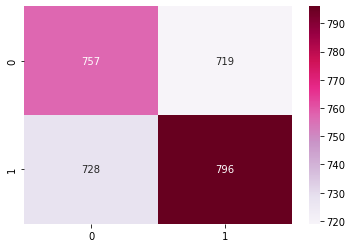


 Classification Report: 
               precision    recall  f1-score   support

           0       0.51      0.51      0.51      1476
           1       0.53      0.52      0.52      1524

    accuracy                           0.52      3000
   macro avg       0.52      0.52      0.52      3000
weighted avg       0.52      0.52      0.52      3000



In [79]:
y_pred = classifier.predict(X_valid)
print(colored('\n Prediction on base parameters:', 'red', attrs=['bold']), accuracy_score(y_valid, y_pred))

print(colored('\n Confusion Matrix: \n', 'red', attrs=['bold']))
confusion_matrice = confusion_matrix(y_valid, y_pred)
sn.heatmap(confusion_matrice, annot = True, cmap = 'PuRd', fmt='g')
plt.show()

print(colored('\n Classification Report: \n', 'red', attrs=['bold']), classification_report(y_valid, y_pred))

### <font color = Darkgrey>${\textbf{XGboost Parameters Tunning using Grid Search}}$</font>

In [80]:
params={"learning_rate" : [0.05, 0.1, 0.3], 
        "max_depth" : [12, 15]
       }

In [81]:
grid_search = GridSearchCV(estimator = classifier, param_grid = params, scoring = 'f1', n_jobs = -1, cv = 5)

In [82]:
start_time = timer(None) # timing starts from this point for "start_time" variable
grid_search.fit(X_train, y_train.ravel())
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 14.62 seconds.


In [83]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [84]:
accuracy = grid_search.best_score_
accuracy

0.5357539693352361

In [85]:
grid_tuned_classifier = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=1, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
grid_tuned_classifier.fit(X_train, y_train.ravel())
y_pred = grid_tuned_classifier.predict(X_valid)


 Prediction on base parameters: 0.545

 Confusion Matrix: 



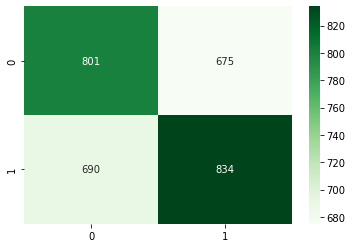


 Classification Report: 
               precision    recall  f1-score   support

           0       0.54      0.54      0.54      1476
           1       0.55      0.55      0.55      1524

    accuracy                           0.55      3000
   macro avg       0.54      0.54      0.54      3000
weighted avg       0.55      0.55      0.55      3000



In [87]:
print(colored('\n Prediction on base parameters:', 'red', attrs=['bold']), accuracy_score(y_valid, y_pred))

print(colored('\n Confusion Matrix: \n', 'red', attrs=['bold']))
confusion_matrice = confusion_matrix(y_valid, y_pred)
sn.heatmap(confusion_matrice, annot = True, cmap = 'Greens', fmt='g')
plt.show()

print(colored('\n Classification Report: \n', 'red', attrs=['bold']), classification_report(y_valid, y_pred))

In [88]:
xgb_feature_imp = pd.DataFrame(list(grid_tuned_classifier.get_booster().get_fscore().items()), 
                               columns = ['feature','importance']).sort_values('importance', ascending=False)
xgb_feature_imp.head(10)

,feature,importance
1,entropy,2605.0
2,letter_count,2418.0
5,words_avg,2379.0
4,specialChar,1525.0
3,num.,1263.0
0,digits_count,852.0


In [89]:
print(colored('\nXGBoost feature importance Top(20): \n', 'green', attrs=['bold']))
print(colored(list(xgb_feature_imp.feature.head(20)), 'blue'))


XGBoost feature importance Top(20): 

['entropy', 'letter_count', 'words_avg', 'specialChar', 'num.', 'digits_count']


In [90]:
model_scores(grid_tuned_classifier, 'Grid tuned XGBoost')


 Results for each classification algorithm:


,Model,Precision,Recall,Accuracy,F1_score
0,Random Forest,0.553008,0.552958,0.552667,0.552628
1,Logistic Regression,0.542775,0.542419,0.541667,0.540992
2,Decision Tree,0.246,0.5,0.492,0.329759
3,K-nearest neighbors,0.529111,0.528503,0.527333,0.525348
4,Sklearn Gradient Boosting,0.52354,0.523539,0.523667,0.52354
5,Grid tuned XGBoost,0.544954,0.544964,0.545,0.544945


### <font color = Darkgrey>${\textbf{XGboost Parameters Tunning using Randomized Search}}$</font>

In [91]:
params = {"learning_rate" : [0.05, 0.1, 0.2, 0.3, 1],
          "max_depth" : [10, 12, 15],
          "min_child_weight" : [1, 3],
          "gamma" : [0.0, 0.15, 0.3]
         }

In [92]:
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = params, n_iter = 10, scoring = 'f1',
                                   n_jobs = -1, cv = 5)

In [93]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train.ravel())
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 16.76 seconds.


In [94]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X_train, y_train.ravel())
timer(start_time) # timing ends here for "start_time" variable


 Time taken: 0 hours 0 minutes and 16.35 seconds.


In [95]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [96]:
random_search.best_params_

{'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.05, 'gamma': 0.3}

In [97]:
random_tuned_classifier = XGBClassifier(base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1,
              colsample_bynode = 1, colsample_bytree = 1, gamma = 0.0, gpu_id = -1,
              importance_type = 'gain', interaction_constraints = '',
              learning_rate = 0.2, max_delta_step = 0, max_depth = 15,
              min_child_weight = 3, missing = 1, monotone_constraints = '()',
              n_estimators = 100, n_jobs= 8, num_parallel_tree = 1, random_state = 0,
              reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, subsample = 1,
              tree_method = 'exact', validate_parameters = 1, verbosity = None)

In [98]:
random_tuned_classifier.fit(X_train, y_train.ravel())
y_pred = random_tuned_classifier.predict(X_valid)


 Prediction on base parameters: 0.527

 Confusion Matrix: 



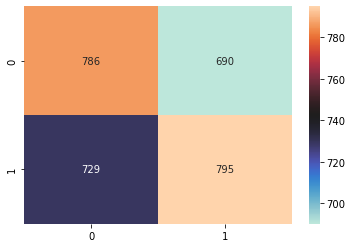


 Classification Report: 
               precision    recall  f1-score   support

           0       0.52      0.53      0.53      1476
           1       0.54      0.52      0.53      1524

    accuracy                           0.53      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.53      0.53      0.53      3000



In [99]:
print(colored('\n Prediction on base parameters:', 'red', attrs=['bold']), accuracy_score(y_valid, y_pred))

print(colored('\n Confusion Matrix: \n', 'red', attrs=['bold']))
confusion_matrice = confusion_matrix(y_valid, y_pred)
sn.heatmap(confusion_matrice, annot = True, cmap = 'icefire', fmt='g')
plt.show()

print(colored('\n Classification Report: \n', 'red', attrs=['bold']), classification_report(y_valid, y_pred))

### <font color = Darkgrey>${\textbf{XGboost Conclusion}}$</font>

**<font color = Darkred>${\textbf{The model accuracy can get better by adding more features and use do more hyperparameters tunning indeed 👾 🤖}}$</font>**


In [100]:
print(colored('\n Results for each classification algorithm: \n', 'magenta', attrs=['bold']))


def highlight_max(x):
    return ['font-weight: bold' if v == x.loc['Grid tuned XGBoost'] else '' for v in x]


final_results = results.set_index(results.Model).drop(['Model'], axis = 1).sort_values(['Precision'])
final_results.style.apply(highlight_max)


 Results for each classification algorithm: 



,Precision,Recall,Accuracy,F1_score
Model,,,,
Decision Tree,0.246000,0.500000,0.492000,0.329759
Sklearn Gradient Boosting,0.523540,0.523539,0.523667,0.523540
K-nearest neighbors,0.529111,0.528503,0.527333,0.525348
Logistic Regression,0.542775,0.542419,0.541667,0.540992
Grid tuned XGBoost,0.544954,0.544964,0.545000,0.544945
Random Forest,0.553008,0.552958,0.552667,0.552628
